## 3. (30 points) Implementing dropout for a fully connected network, and optimizing it.
***

# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

Utils has a solid API for building these modular frameworks and training them, and we will use this very well implemented framework as opposed to "reinventing the wheel."  This includes using the Solver, various utility functions, and the layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.99933208960986
Mean of train-time output:  10.018005552224844
Mean of test-time output:  9.99933208960986
Fraction of train-time output set to zero:  0.699408
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99933208960986
Mean of train-time output:  10.00281461319211
Mean of test-time output:  9.99933208960986
Fraction of train-time output set to zero:  0.399952
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99933208960986
Mean of train-time output:  9.99769380069838
Mean of test-time output:  9.99933208960986
Fraction of train-time output set to zero:  0.250088
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445609202235416e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.309771209610118
W1 relative error: 2.694274363733021e-07
W2 relative error: 7.439246147919978e-08
W3 relative error: 1.910371122296728e-08
b1 relative error: 4.112891126518e-09
b2 relative error: 5.756217724722137e-10
b3 relative error: 1.3204470857080166e-10


Running check with dropout =  0.75
Initial loss:  2.306133548427975
W1 relative error: 8.72986097970181e-08
W2 relative error: 2.9777307885797295e-07
W3 relative error: 1.8832780806174298e-08
b1 relative error: 5.379486003985169e-08
b2 relative error: 3.6529949080385546e-09
b3 relative error: 9.987242764516995e-11


Running check with dropout =  1.0
Initial loss:  2.3053332250963194
W1 relative error: 1.2744095365229032e-06
W2 relative error: 4.678743300473988e-07
W3 relative error: 4.331673892536035e-08
b1 relative error: 4.0853539035931665e-08
b2 relative error: 1.951342257912746e-09
b3 relative error: 9.387142701440351e-11




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300199
(Epoch 0 / 25) train acc: 0.158000; val_acc: 0.127000
(Epoch 1 / 25) train acc: 0.132000; val_acc: 0.121000
(Epoch 2 / 25) train acc: 0.204000; val_acc: 0.170000
(Epoch 3 / 25) train acc: 0.240000; val_acc: 0.192000
(Epoch 4 / 25) train acc: 0.312000; val_acc: 0.274000
(Epoch 5 / 25) train acc: 0.314000; val_acc: 0.269000
(Epoch 6 / 25) train acc: 0.364000; val_acc: 0.252000
(Epoch 7 / 25) train acc: 0.390000; val_acc: 0.281000
(Epoch 8 / 25) train acc: 0.386000; val_acc: 0.290000
(Epoch 9 / 25) train acc: 0.372000; val_acc: 0.267000
(Epoch 10 / 25) train acc: 0.424000; val_acc: 0.286000
(Epoch 11 / 25) train acc: 0.396000; val_acc: 0.275000
(Epoch 12 / 25) train acc: 0.458000; val_acc: 0.299000
(Epoch 13 / 25) train acc: 0.496000; val_acc: 0.305000
(Epoch 14 / 25) train acc: 0.492000; val_acc: 0.299000
(Epoch 15 / 25) train acc: 0.550000; val_acc: 0.296000
(Epoch 16 / 25) train acc: 0.584000; val_acc: 0.297000
(Epoch 17 / 25) train acc: 0.582000; val

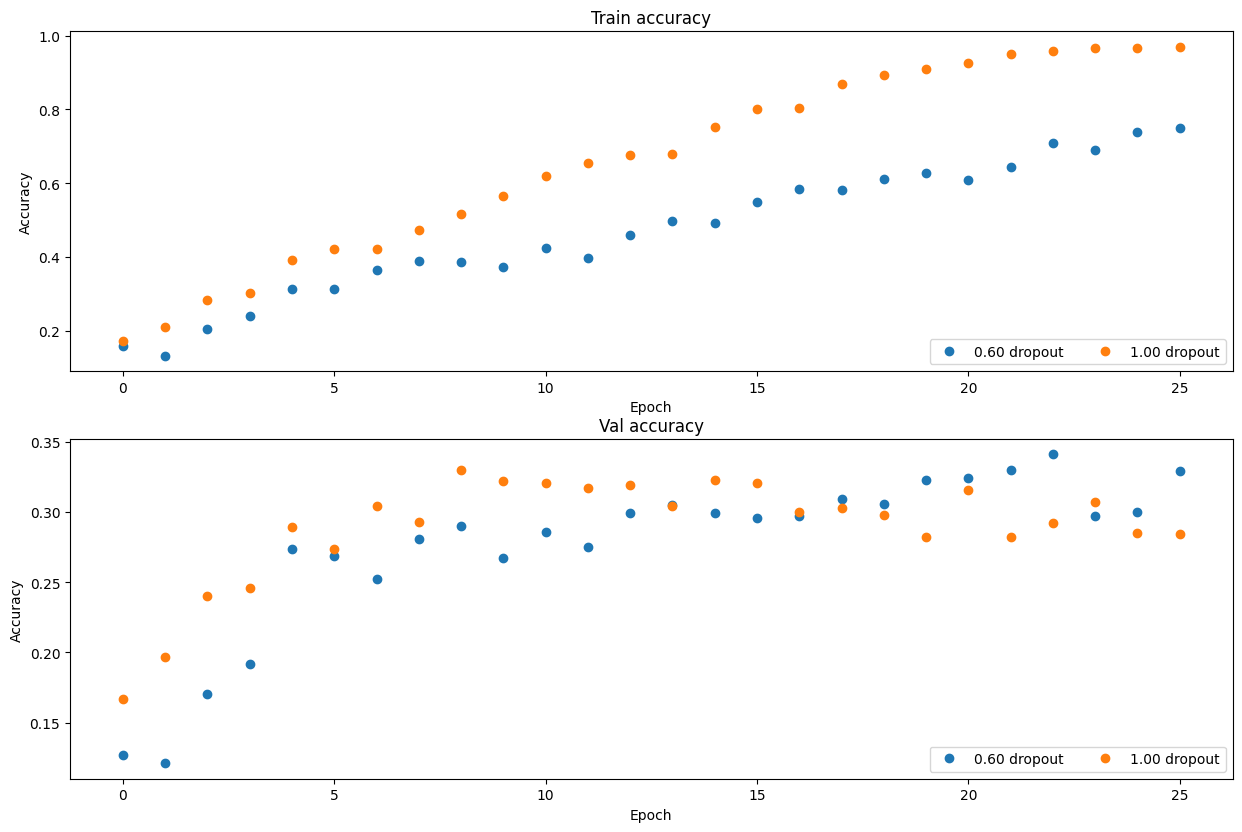

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

Yes, it is. As we can see in the two figures above, even if the model with dropout has lower training accuracies, it has similar performance on validation set with one without dropout. This means that dropout can provide regularization to prevent a model from overfitting the training data.

##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

In [8]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #

# model config
layer_dims = [100, 100, 100]
weight_scale = 0.01
use_batchnorm = True
dropout = 0.9

# trainer config
num_epochs = 10
batch_size = 100
optimizer = "adam"
learning_rate = 5e-4
lr_decay = 0.9

model = FullyConnectedNet(
    layer_dims,
    weight_scale=weight_scale,
    use_batchnorm=use_batchnorm,
    dropout=dropout,
)

solver = Solver(
    model,
    data,
    num_epochs=num_epochs,
    batch_size=batch_size,
    update_rule=optimizer,
    optim_config={
      "learning_rate": learning_rate,
    },
    lr_decay=lr_decay,
    verbose=True,
    print_every=4900,
)
solver.train()

y_test_pred = np.argmax(model.loss(data["X_test"]), axis=1)
y_val_pred = np.argmax(model.loss(data["X_val"]), axis=1)
print("Validation set accuracy: {}".format(np.mean(y_val_pred == data["y_val"])))
print("Test set accuracy: {}".format(np.mean(y_test_pred == data["y_test"])))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 4900) loss: 2.304780
(Epoch 0 / 10) train acc: 0.110000; val_acc: 0.135000
(Epoch 1 / 10) train acc: 0.462000; val_acc: 0.468000
(Epoch 2 / 10) train acc: 0.517000; val_acc: 0.510000
(Epoch 3 / 10) train acc: 0.554000; val_acc: 0.508000
(Epoch 4 / 10) train acc: 0.547000; val_acc: 0.519000
(Epoch 5 / 10) train acc: 0.580000; val_acc: 0.552000
(Epoch 6 / 10) train acc: 0.600000; val_acc: 0.545000
(Epoch 7 / 10) train acc: 0.601000; val_acc: 0.548000
(Epoch 8 / 10) train acc: 0.614000; val_acc: 0.546000
(Epoch 9 / 10) train acc: 0.628000; val_acc: 0.563000
(Epoch 10 / 10) train acc: 0.644000; val_acc: 0.579000
Validation set accuracy: 0.579
Test set accuracy: 0.562


In [ ]:
# layers.py
import numpy as np
import pdb


def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    assert (0<p<=1), "Dropout probability is not in (0,1]"
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        
        out = x
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        
        dx = dout * mask

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        
        dx = dout
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

In [ ]:
# fc_net.py
import numpy as np
import pdb

from .layers import *
from .layer_utils import *


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be
    
    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
    
    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.
    
    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=1, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.
        
        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout < 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize all parameters of the network in the self.params dictionary.
        #   The weights and biases of layer 1 are W1 and b1; and in general the 
        #   weights and biases of layer i are Wi and bi. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #
        #   BATCHNORM: Initialize the gammas of each layer to 1 and the beta
        #   parameters to zero.  The gamma and beta parameters for layer 1 should
        #   be self.params['gamma1'] and self.params['beta1'].  For layer 2, they
        #   should be gamma2 and beta2, etc. Only use batchnorm if self.use_batchnorm 
        #   is true and DO NOT do batch normalize the output scores.
        # ================================================================ #
        
        layer_dims = [input_dim] + hidden_dims + [num_classes]

        # fc layers
        for i in range(self.num_layers):
            self.params["W" + str(i + 1)] = weight_scale * np.random.randn(
                layer_dims[i], layer_dims[i + 1]
            )
            self.params["b" + str(i + 1)] = np.zeros(layer_dims[i + 1])
        
        # bn layers
        if self.use_batchnorm:
            for i in range(self.num_layers - 1):
                self.params["gamma" + str(i + 1)] = np.ones(layer_dims[i + 1])
                self.params["beta" + str(i + 1)] = np.zeros(layer_dims[i + 1])

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
        if seed is not None:
            self.dropout_param['seed'] = seed
    
        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.use_batchnorm:
            self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
        
        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.dropout_param is not None:
            self.dropout_param['mode'] = mode   
        if self.use_batchnorm:
            for bn_param in self.bn_params:
                bn_param['mode'] = mode

        scores = None
    
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the FC net and store the output
        #   scores as the variable "scores".
        #
        #   BATCHNORM: If self.use_batchnorm is true, insert a bathnorm layer
        #   between the affine_forward and relu_forward layers.  You may
        #   also write an affine_batchnorm_relu() function in layer_utils.py.
        #
        #   DROPOUT: If dropout is non-zero, insert a dropout layer after
        #   every ReLU layer.
        # ================================================================ #

        caches = {}
    
        # forward all fc layers except the last one
        for i in range(self.num_layers - 1):
            W = self.params["W" + str(i + 1)]
            b = self.params["b" + str(i + 1)]
            
            if self.use_batchnorm:
                gamma = self.params["gamma" + str(i + 1)]
                beta = self.params["beta" + str(i + 1)]
                X, cache = affine_bn_relu_forward(X, W, b, gamma, beta, self.bn_params[i])
            else:
                X, cache = affine_relu_forward(X, W, b)

            caches[i + 1] = cache
            
            # dropout
            if self.use_dropout:
                X, cache = dropout_forward(X, self.dropout_param)                
                caches["dropout" + str(i + 1)] = cache

        # forward last layer with softmax
        W = self.params["W" + str(self.num_layers)]
        b = self.params["b" + str(self.num_layers)]
        scores, cache = affine_forward(X, W, b)
        caches[self.num_layers] = cache

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backwards pass of the FC net and store the gradients
        #   in the grads dict, so that grads[k] is the gradient of self.params[k]
        #   Be sure your L2 regularization includes a 0.5 factor.
        #
        #   BATCHNORM: Incorporate the backward pass of the batchnorm.
        #
        #   DROPOUT: Incorporate the backward pass of dropout.
        # ================================================================ #

        # compute loss
        loss, dout = softmax_loss(scores, y)

        # add regularization loss
        for i in range(self.num_layers):
            W = self.params["W" + str(i + 1)]
            loss += 0.5 * self.reg * (W * W).sum()

        # backward last fc layer
        dout, dw, grads["b" + str(self.num_layers)] = affine_backward(dout, caches[self.num_layers])
        W = self.params["W" + str(self.num_layers)]
        grads["W" + str(self.num_layers)] = dw + self.reg * W

        # backward for all other fc layers
        for i in range(self.num_layers - 2, -1, -1):
            # dropout
            if self.use_dropout:
                dout = dropout_backward(dout, caches["dropout" + str(i + 1)])

            if self.use_batchnorm:          
                dout, dw, db, dgamma, dbeta = affine_bn_relu_backward(dout, caches[i + 1])
                grads["gamma" + str(i + 1)] = dgamma
                grads["beta" + str(i + 1)] = dbeta
            else:
                dout, dw, db = affine_relu_backward(dout, caches[i + 1])

            W = self.params["W" + str(i + 1)]
            grads["W" + str(i + 1)] = dw + self.reg * W
            grads["b" + str(i + 1)] = db

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        return loss, grads